In [24]:
%pip install matplotlib

                                              0.0/8.0 MB ? eta -:--:--
     -----                                    1.1/8.0 MB 36.3 MB/s eta 0:00:01
     -----------------                        3.5/8.0 MB 37.0 MB/s eta 0:00:01
     ----------------------------             5.6/8.0 MB 45.0 MB/s eta 0:00:01
     ---------------------------------------  7.9/8.0 MB 42.2 MB/s eta 0:00:01
     ---------------------------------------- 8.0/8.0 MB 36.5 MB/s eta 0:00:00
                                              0.0/187.5 kB ? eta -:--:--
     ------------------------------------- 187.5/187.5 kB 11.1 MB/s eta 0:00:00
                                              0.0/2.2 MB ? eta -:--:--
     --------------------------------------   2.1/2.2 MB 46.1 MB/s eta 0:00:01
     ---------------------------------------- 2.2/2.2 MB 28.1 MB/s eta 0:00:00
                                              0.0/56.1 kB ? eta -:--:--
     ---------------------------------------- 56.1/56.1 kB ? eta 0:00:00
       


[notice] A new release of pip is available: 23.1.2 -> 24.1.2
[notice] To update, run: C:\Users\music\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [39]:
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

In [40]:
def intersec2Circle(x1,y1,r1,x2,y2,r2):
    # soltion at https://www.desmos.com/calculator/rpqz6q10eb
    c1 = np.array([x1,y1])
    c2 = np.array([x2,y2])
    v = c2-c1
    d = np.linalg.norm(v)
    ux = v/d
    uy = np.array([ux[1], -ux[0]])
    xvec = ((d**2)-(r2**2)+(r1**2))/2/d
    yvec = math.sqrt(r2**2-(d-xvec)**2)
    return c1+ux*xvec+uy*yvec,c1+ux*xvec-uy*yvec

def distance(posA, posB):
    return np.linalg.norm(posA - posB)

In [41]:
class Env:
    def __init__(self, time_step=0.001):
        self.obj_dict = {}
        self.time_step = time_step
        self.time = 0.0
        self.id_number = 0

    def set_object(self, position, obj_type, direction=np.array([1, 0]), speed=0):
        if obj_type == "radar":
            obj = Radar(self.id_number, position)
        elif obj_type == "photon":
            obj = Photon(self.id_number, self.time, position, direction, speed)
        else:
            obj = Object(self.id_number, position, direction, speed)
        self.obj_dict[self.id_number] = obj
        print(f"Object {self.id_number} added: {obj_type}")
        self.id_number += 1

    def remove_object(self, obj_id):
        if obj_id in self.obj_dict:
            del self.obj_dict[obj_id]
            print(f"Object {obj_id} removed")
        else:
            print(f"Object {obj_id} not found")
            
    def run_step(self):
        obj_keys = list(self.obj_dict.keys())
        for obj_key in obj_keys:
            if obj_key in self.obj_dict:
                self.obj_dict[obj_key].update(self)
        self.time = round(self.time + self.time_step, 3)

    # def run(self, till_time, log=False):
    #     while self.time <= till_time:
    #         if log and (self.time * 10) % 1 == 0:
    #             print("Running....", self.time)
    #                     # Create a list of keys to iterate over to avoid dictionary size change errors
    #         obj_keys = list(self.obj_dict.keys())
    #         for obj_key in obj_keys:
    #             if obj_key in self.obj_dict:  # Check if the object still exists in the dictionary
    #                 self.obj_dict[obj_key].update(self)
    #         self.time = round(self.time + self.time_step, 3)

class Object:
    def __init__(self, ID, position=np.array([0, 0]), direction=np.array([1, 0]), speed=0, obj_type="obj"):
        self.id = ID
        self.type = obj_type
        self.pos = position
        self.dir = direction
        self.speed = speed
        self.velocity = speed * direction

    def __str__(self):
        return f"id:{self.id} | type:{self.type} | position:{self.pos} | direction:({self.dir}) | velocity:{self.velocity}"

    def move(self, time):
        self.pos = self.pos + self.velocity * time

    def update(self, env):
        self.move(env.time_step)

class Radar(Object):
    def __init__(self, ID, position=np.array([0, 0])):
        super().__init__(ID=ID, position=position, obj_type="radar")
        self.distance = 0

    def send_photon(self, env):
        env.set_object(self.pos + self.dir * 0.1, 'photon', direction=self.dir, speed=100)

    def receive_photon(self, speed, time, start_time):
        delta_time = time - start_time
        self.distance = delta_time * speed / 2
        print(f"Photon received. Time: {delta_time:.4f}s, Distance: {self.distance:.4f}m.")

    def update(self, env):
        if env.time == 0.01:
            print("Sending photon....", env.time)
            self.send_photon(env)
                        # Create a list of keys to iterate over to avoid dictionary size change errors
        obj_keys = list(env.obj_dict.keys())
        for obj_key in obj_keys:
            if obj_key in env.obj_dict:  # Check if the object still exists in the dictionary
                obj = env.obj_dict[obj_key]
                if obj.type == "photon":
                    if distance(self.pos, obj.pos) <= 0.01:
                        self.receive_photon(obj.speed, env.time, obj.time)
                        env.remove_object(obj.id)

class Photon(Object):
    def __init__(self, ID, start_time, position=np.array([0, 0]), direction=np.array([1, 0]), speed=0):
        super().__init__(ID, position=position, obj_type="photon", direction=direction, speed=speed)
        self.start_pos = position
        self.time = start_time

    def collision(self, env):
        for obj in env.obj_dict.values():
            if obj.type != "photon" and distance(self.pos, obj.pos) <= 0.01:
                self.velocity *= -1

    def update(self, env):
        self.move(env.time_step)
        self.collision(env)
            

        

In [42]:
# Visualization with Matplotlib
def animate(i):
    env.run_step()
    ax.clear()
    radar_positions = [obj['pos'] for obj in env.obj_dict.values() if obj['type'] == "radar"]
    photon_positions = [obj['pos'] for obj in env.obj_dict.values() if obj['type'] == "photon"]
    object_positions = [obj['pos'] for obj in env.obj_dict.values() if obj['type'] == "obj"]
    
    if radar_positions:
        radar_positions = np.array(radar_positions)
        ax.plot(radar_positions[:, 0], radar_positions[:, 1], 'bo', label='Radar')
    
    if photon_positions:
        photon_positions = np.array(photon_positions)
        ax.plot(photon_positions[:, 0], photon_positions[:, 1], 'ro', label='Photon')
    
    if object_positions:
        object_positions = np.array(object_positions)
        ax.plot(object_positions[:, 0], object_positions[:, 1], 'go', label='Object')
    
    ax.set_xlim(-5, 30)
    ax.set_ylim(-5, 5)
    ax.legend()

In [93]:
a = [np.array([100,100]),np.array([-100,-100])]
pos = np.array([100,-101])

def in_map(pos):
    return (pos<=a[0]).all() and (pos>=a[1]).all()

if not in_map(pos):
    print("out...")

out...


In [106]:
np.arctan2(0,1)

0.0

In [95]:
for i in range(178):
    angle = (np.pi/180) * i + 1
    direction = np.array([np.cos(angle), np.sin(angle)])-np.array()
    print(direction)

[1. 0.]
[0.9998477 0.       ]
[0.99939083 0.        ]
[0.99862953 0.        ]
[0.99756405 0.        ]
[0.9961947 0.       ]
[0.9945219 0.       ]
[0.99254615 0.        ]
[0.99026807 0.        ]
[0.98768834 0.        ]
[0.98480775 0.        ]
[0.98162718 0.        ]
[0.9781476 0.       ]
[0.97437006 0.        ]
[0.97029573 0.        ]
[0.96592583 0.        ]
[0.9612617 0.       ]
[0.95630476 0.        ]
[0.95105652 0.        ]
[0.94551858 0.        ]
[0.93969262 0.        ]
[0.93358043 0.        ]
[0.92718385 0.        ]
[0.92050485 0.        ]
[0.91354546 0.        ]
[0.90630779 0.        ]
[0.89879405 0.        ]
[0.89100652 0.        ]
[0.88294759 0.        ]
[0.87461971 0.        ]
[0.8660254 0.       ]
[0.8571673 0.       ]
[0.8480481 0.       ]
[0.83867057 0.        ]
[0.82903757 0.        ]
[0.81915204 0.        ]
[0.80901699 0.        ]
[0.79863551 0.        ]
[0.78801075 0.        ]
[0.77714596 0.        ]
[0.76604444 0.        ]
[0.75470958 0.        ]
[0.74314483 0.        ]


In [69]:
env = Env()
env.set_object(position=np.array([0.0, 0.0]), obj_type="radar")
env.set_object(position=np.array([2.0, 0.0]), obj_type="radar")
env.set_object(position=np.array([21.0, 0.0]), obj_type="obj")
# env.run(10, log=True)


Object 0 added: radar
Object 1 added: radar
Object 2 added: obj


In [70]:
for obj in env.obj_dict.values():
    print(obj)

id:0 | type:radar | position:[0. 0.] | direction:([1 0]) | velocity:[0 0]
id:1 | type:radar | position:[2. 0.] | direction:([1 0]) | velocity:[0 0]
id:2 | type:obj | position:[21.  0.] | direction:([1 0]) | velocity:[0 0]


In [73]:
rapos = [obj.pos for obj in env.obj_dict.values() if obj.type == "radar"]
rapos

[array([0., 0.]), array([2., 0.])]

In [76]:
x = [rapo[0] for rapo in rapos]
y = [rapo[1] for rapo in rapos]
print(x)
print(y)

[0.0, 2.0]
[0.0, 0.0]


In [5]:
env.run(30,env,log=False)


running.... 0.0
sendPhoton.... 0.01
Object added
running.... 0.1
running.... 0.2
knocked....
running.... 0.3
running.... 0.4
knocked....
0.42  0  100
hit>>>>>>>  21.0 m.
running.... 0.5
running.... 0.6
knocked....
running.... 0.7
running.... 0.8
knocked....
0.84  0  0
hit>>>>>>>  0.0 m.
running.... 0.9
running.... 1.0
knocked....
running.... 1.1
running.... 1.2
knocked....
1.26  0  0
hit>>>>>>>  0.0 m.
running.... 1.3
running.... 1.4
knocked....
running.... 1.5
running.... 1.6
knocked....
1.6800000000000002  0  0
hit>>>>>>>  0.0 m.
running.... 1.7
running.... 1.8
knocked....
running.... 1.9
running.... 2.0
running.... 2.1
knocked....
2.1  0  0
hit>>>>>>>  0.0 m.
running.... 2.2
running.... 2.3
knocked....
running.... 2.4
running.... 2.5
knocked....
2.52  0  0
hit>>>>>>>  0.0 m.
running.... 2.6
running.... 2.7
knocked....
running.... 2.8
running.... 2.9
knocked....
2.94  0  0
hit>>>>>>>  0.0 m.
running.... 3.0
running.... 3.1
knocked....
running.... 3.2
running.... 3.3
knocked....
3.360

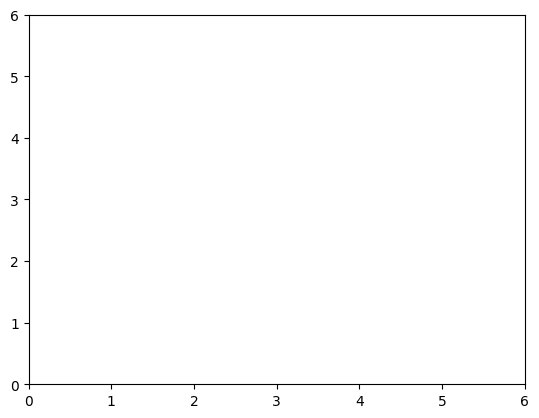

In [61]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

# List of coordinates
coordinates = [(1, 1), (2, 2), (3, 3), (4, 4), (5, 5)]

# Set up the figure and axes
fig, ax = plt.subplots()
ax.set_xlim(0, 6)
ax.set_ylim(0, 6)

# Initialize the plot
point, = ax.plot([], [], 'ro')

# Initialization function
def init():
    point.set_data([], [])
    return point,

# Animation function
def animate(i):
    x, y = coordinates[i]
    point.set_data([x], [y])
    return point,

# Create the animation
ani = FuncAnimation(fig, animate, init_func = init,  
                               frames = 5, interval = 200, blit = True)

# Display the animation
plt.show()


In [221]:
envi.objList[0].distance

0.0

In [207]:
type(envi.objList[0].pos)

numpy.ndarray

In [212]:
print((np.array([1,0]) == np.array([1,0])).all())

True


In [292]:
3.00%1

0.0

In [170]:
class env:
    def __init__(self) -> None:
        self.object = {}
        self.time = datetime.now()
        self.ID = 0
        self.posList = []
        
    def createObject(self,type,position,radarID,direction = np.array([1,0]),speed = 0):
        if type == "radar":
            obj = {
                "id": self.ID,
                "type":"radar",
                "pos" : position,
                "dirt" : direction,
                "distacce": -1
                }
            self.posList(position)
        elif type == "photon":
            obj = {
                "id": self.ID,
                "type":"photon",
                "pos" : position,
                "dirt" : direction,
                "speed" : speed,
                "velocity" : speed*direction,
                "radarID" : radarID,
            }
            
        self.ID += 1
        self.object[obj["id"]] = obj
        
    def sendPhoton(self,position,radarID,direction,speed):
        self.createObject("photon",position,radarID,direction,speed)
        
        
    def move(self,time):
        oldTime = self.time
        newTime = datetime.now()
        self.pos+=self.velocity*(newTime-oldTime)
        self.time = newTime
        
    def collition(self,obj):
        if pos in self.posList:
            self.velocity *= -1
        if self.pos

    def measure(self,pos,direc,speed,radarID):
        timeSend = datetime.now()
        self.sendPhoton(pos,radarID,direc,speed)
        deltaTime = datetime.now()-timeSend
        return deltaTime*speed


SyntaxError: expected ':' (1327892887.py, line 45)

In [ ]:
{"1":{"pos":0},"2":{"pos":1}}